In [1]:
import numpy as np
import pandas as pd
import json
import os
import math
import librosa
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configurar las credenciales de Kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Descargar el conjunto de datos de Kaggle
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

# Descomprimir el conjunto de datos descargado
!unzip gtzan-dataset-music-genre-classification.zip -d gtzan_dataset
%%capture

mv: cannot stat 'kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
License(s): other
gtzan-dataset-music-genre-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  gtzan-dataset-music-genre-classification.zip
replace gtzan_dataset/Data/features_30_sec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

UsageError: Line magic function `%%capture` not found.


In [4]:
csv_path = 'gtzan_dataset/Data/features_30_sec.csv'
df = pd.read_csv(csv_path)
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [5]:
df.columns

Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

# EDA

In [6]:
df.describe()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,662030.846000,0.378682,0.086340,0.130930,0.003051,2201.780898,4.696916e+05,2242.541070,137079.155165,4571.549304,...,1.148144,60.730958,-3.966028,62.633624,0.507696,63.712586,-2.328761,66.231930,-1.095348,70.126096
std,1784.073992,0.081705,0.007735,0.065683,0.003634,715.960600,4.008995e+05,526.316473,96455.666326,1574.791602,...,4.578948,33.781951,4.549697,33.479172,3.869105,34.401977,3.755957,37.174631,3.837007,45.228512
min,660000.000000,0.171939,0.044555,0.005276,0.000004,570.040355,7.911251e+03,898.066208,10787.185064,749.140636,...,-15.693844,9.169314,-17.234728,13.931521,-11.963694,15.420555,-18.501955,13.487622,-19.929634,7.956583
25%,661504.000000,0.319562,0.082298,0.086657,0.000942,1627.697311,1.843505e+05,1907.240605,67376.554428,3380.069642,...,-1.863280,40.376442,-7.207225,40.830875,-2.007015,41.884240,-4.662925,41.710184,-3.368996,42.372865
50%,661794.000000,0.383148,0.086615,0.122443,0.001816,2209.263090,3.384862e+05,2221.392843,111977.548036,4658.524473,...,1.212809,52.325077,-4.065605,54.717674,0.669643,54.804890,-2.393862,57.423059,-1.166289,59.186117
75%,661794.000000,0.435942,0.091256,0.175682,0.003577,2691.294667,6.121479e+05,2578.469836,182371.576801,5533.810460,...,4.359662,71.691755,-0.838737,75.040838,3.119212,75.385832,0.150573,78.626444,1.312615,85.375374
max,675808.000000,0.663685,0.108111,0.397973,0.027679,4435.243901,3.036843e+06,3509.646417,694784.811549,8677.672688,...,13.457150,392.932373,11.482946,406.058868,15.388390,332.905426,14.694924,393.161987,15.369627,506.065155


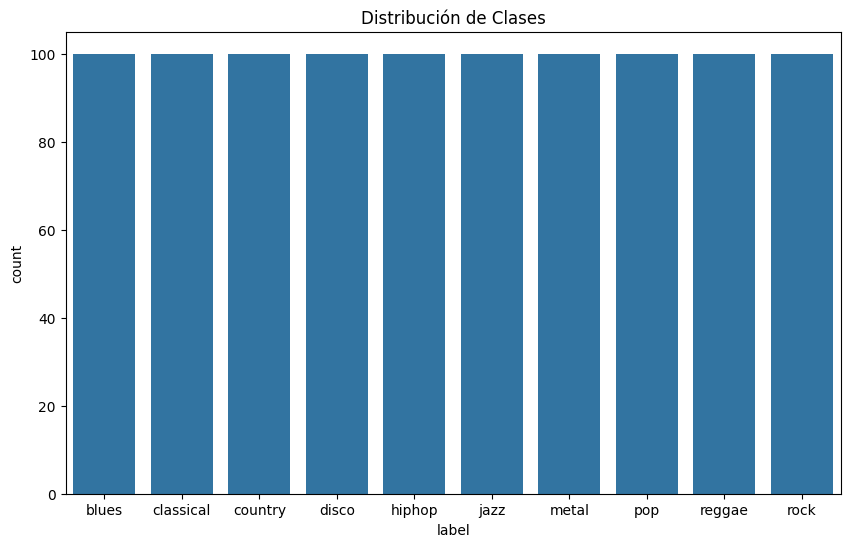

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df)
plt.title('Distribución de Clases')
plt.show()

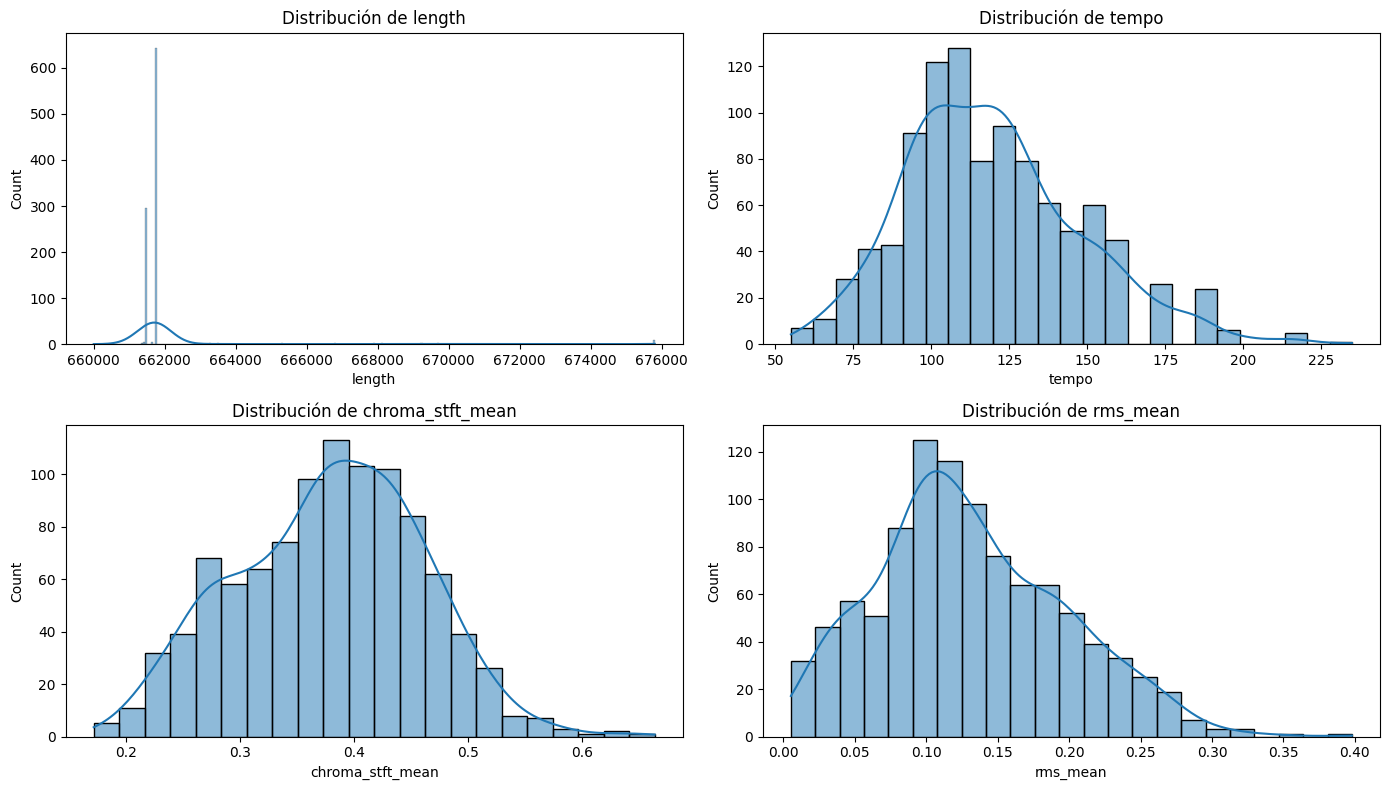

In [8]:
plt.figure(figsize=(14, 8))
for i, column in enumerate(['length', 'tempo', 'chroma_stft_mean', 'rms_mean'], 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[column], kde=True, palette="coolwarm")
    plt.title(f'Distribución de {column}')
plt.tight_layout()
plt.show()


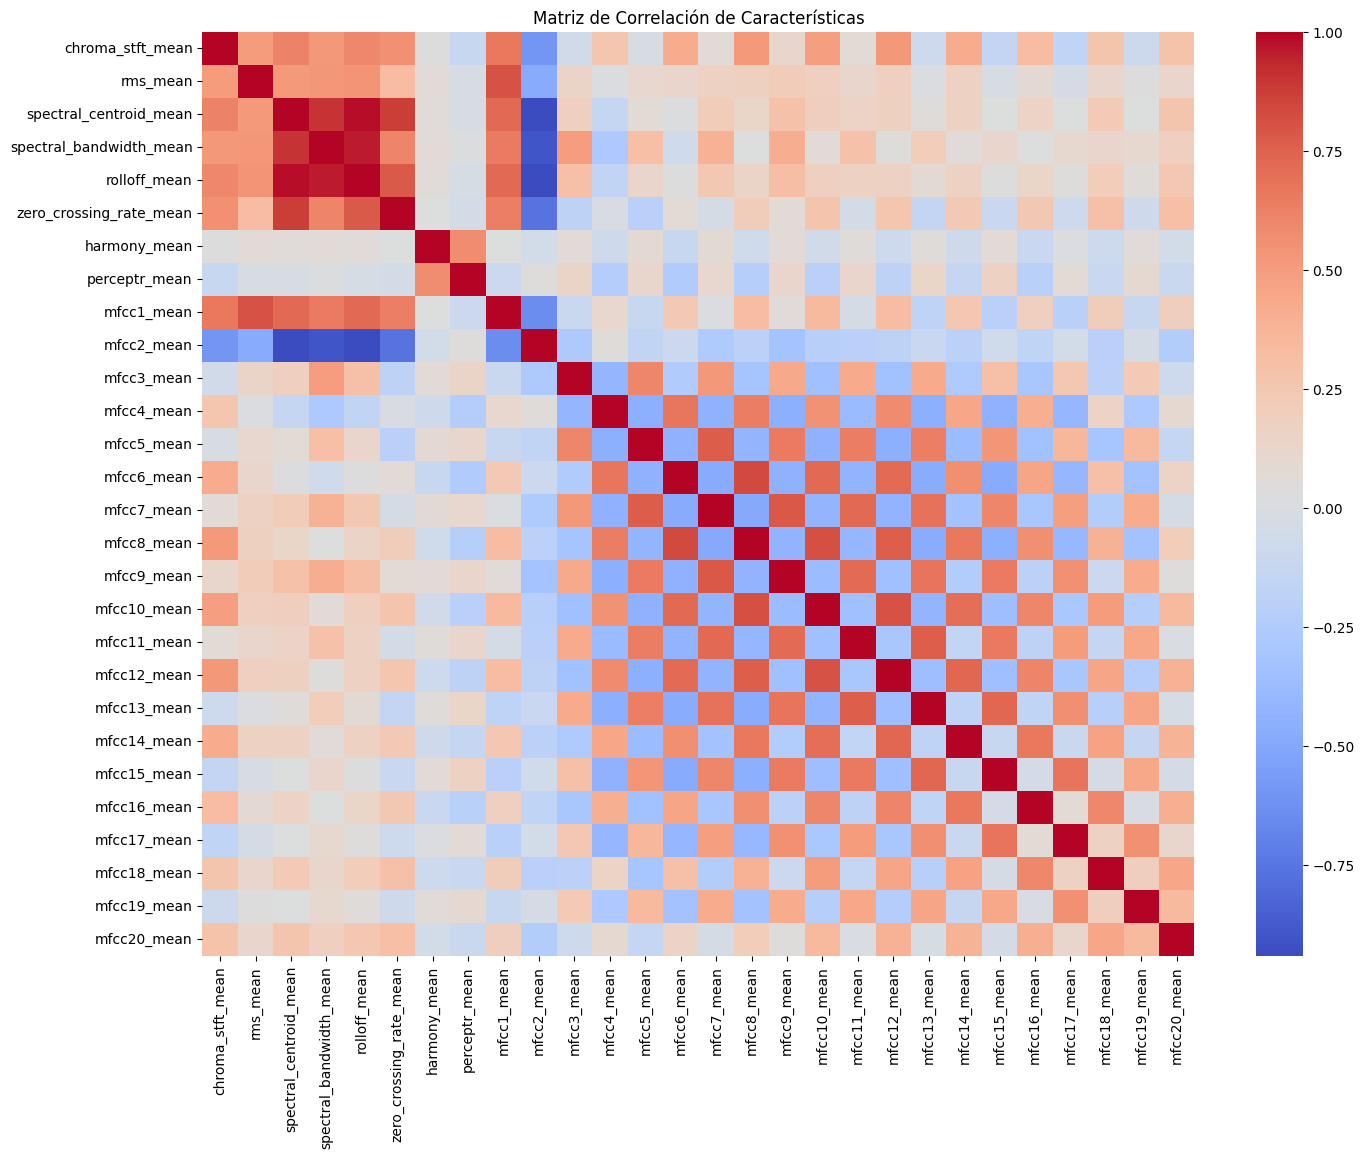

In [9]:
# Computing the Correlation Matrix for mean variables
mean_cols = [col for col in df.columns if 'mean' in col]
corr = df[mean_cols].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Matriz de Correlación de Características')
plt.show()


### Visualización de Características por Clase:

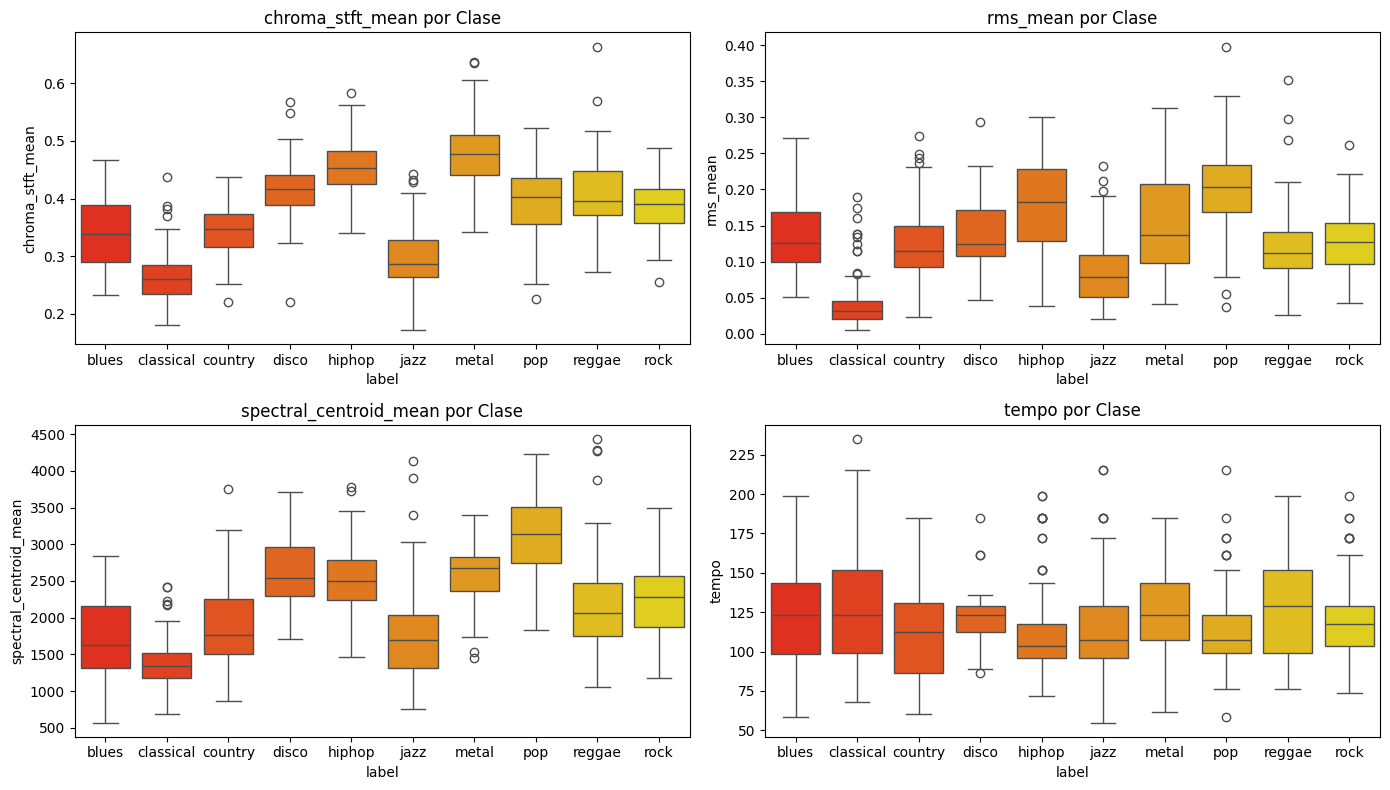

In [10]:
plt.figure(figsize=(14, 8))
for i, column in enumerate(['chroma_stft_mean', 'rms_mean', 'spectral_centroid_mean', 'tempo'], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='label', y=column, data=df, palette='autumn')
    plt.title(f'{column} por Clase')
plt.tight_layout()
plt.show()


### Outliers

In [11]:
from sklearn.neighbors import LocalOutlierFactor

# Create a copy of the DataFrame
df1 = df.copy()

# Select numerical columns
num_cols = df.select_dtypes(include=['int64', 'float64'])

# Instantiate LOF
lof_outlier = LocalOutlierFactor(n_neighbors=5)

# Fit and predict outliers
outlier_scores = lof_outlier.fit_predict(num_cols)

# Add outlier scores as a new column in df1
df1['LOF_outlier_scores'] = outlier_scores

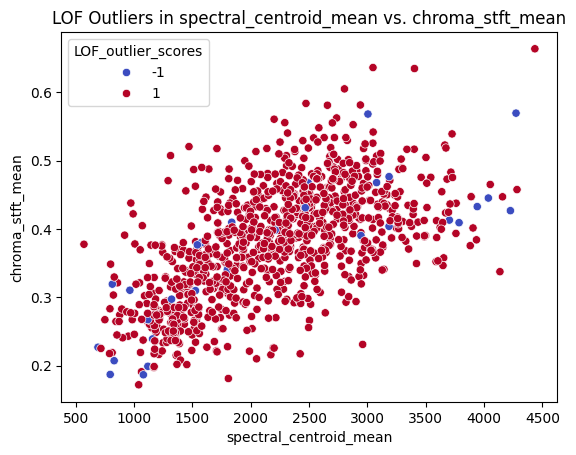

In [12]:
sns.scatterplot(df1, x="spectral_centroid_mean", y="chroma_stft_mean", hue="LOF_outlier_scores", palette="coolwarm")
plt.title("LOF Outliers in spectral_centroid_mean vs. chroma_stft_mean")
plt.show()

# Preprocessing

In [13]:
df_prep = df.drop('filename', axis=1)


In [14]:
y = df_prep['label'] # genre variable.
X = df_prep.loc[:, df_prep.columns != 'label'] #select all columns but not the labels

#### NORMALIZE X ####

# Normalize so everything is on the same scale.

cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

# new data frame with the new scaled data.
X = pd.DataFrame(np_scaled, columns = cols)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(df1['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# ML models

In [15]:
def model_assess(model, title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    #print(confusion_matrix(y_test, preds))
    print('Accuracy', title, ':', round(accuracy_score(y_test, preds), 5), '\n')

In [16]:
# Naive Bayes
nb = GaussianNB()
model_assess(nb, "Naive Bayes")

# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess(sgd, "Stochastic Gradient Descent")

# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, "KNN")

# Decission trees
tree = DecisionTreeClassifier()
model_assess(tree, "Decission trees")

# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest")

# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
model_assess(svm, "Support Vector Machine")

# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_assess(lg, "Logistic Regression")

# Cross Gradient Booster
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
model_assess(xgb, "Cross Gradient Booster")

# Cross Gradient Booster (Random Forest)
xgbrf = XGBRFClassifier(objective= 'multi:softmax')
model_assess(xgbrf, "Cross Gradient Booster (Random Forest)")

Accuracy Naive Bayes : 0.49 

Accuracy Stochastic Gradient Descent : 0.62333 

Accuracy KNN : 0.58 

Accuracy Decission trees : 0.53667 

Accuracy Random Forest : 0.73667 

Accuracy Support Vector Machine : 0.64333 

Accuracy Logistic Regression : 0.62 

Accuracy Cross Gradient Booster : 0.73667 

Accuracy Cross Gradient Booster (Random Forest) : 0.65667 



# Seleccion de features

### Arbol de decision

In [17]:
# from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

for i in range(2, 8, 1):

    # Creamos el modelo para un dado valor de i
    arbol = DecisionTreeClassifier(max_depth = i, random_state = 42)
    arbol.fit(X_train, y_train)
    y_pred_arbol = arbol.predict(X_test)
    print(f'profundidad {i} - Accuracy = {accuracy_score(y_test, y_pred_arbol)}')

profundidad 2 - Accuracy = 0.2733333333333333
profundidad 3 - Accuracy = 0.3466666666666667
profundidad 4 - Accuracy = 0.43666666666666665
profundidad 5 - Accuracy = 0.47333333333333333
profundidad 6 - Accuracy = 0.51
profundidad 7 - Accuracy = 0.52


In [18]:
for i in range(2, 8, 1):

    # Creamos el modelo para un dado valor de i
    arbol = DecisionTreeClassifier(min_samples_split = i, random_state = 42)

    arbol.fit(X_train, y_train)
    y_pred_arbol = arbol.predict(X_test)
    print(f'min_samples_split {i} - Accuracy = {accuracy_score(y_test, y_pred_arbol)}')

min_samples_split 2 - Accuracy = 0.57
min_samples_split 3 - Accuracy = 0.5366666666666666
min_samples_split 4 - Accuracy = 0.5433333333333333
min_samples_split 5 - Accuracy = 0.53
min_samples_split 6 - Accuracy = 0.5566666666666666
min_samples_split 7 - Accuracy = 0.54


In [19]:
for i in range(2, 8, 1):

    # Creamos el modelo para un dado valor de i
    arbol = DecisionTreeClassifier(min_samples_leaf = i, random_state = 42)

    arbol.fit(X_train, y_train)
    y_pred_arbol = arbol.predict(X_test)

    print(f'min_samples_leaf {i} - Accuracy = {accuracy_score(y_test, y_pred_arbol)}')

min_samples_leaf 2 - Accuracy = 0.5433333333333333
min_samples_leaf 3 - Accuracy = 0.5566666666666666
min_samples_leaf 4 - Accuracy = 0.5333333333333333
min_samples_leaf 5 - Accuracy = 0.53
min_samples_leaf 6 - Accuracy = 0.5133333333333333
min_samples_leaf 7 - Accuracy = 0.5266666666666666


In [35]:

best_tree = DecisionTreeClassifier(max_depth = 7, min_samples_split = 2, min_samples_leaf=3, random_state = 42)
# Entrenamiento
best_tree.fit(X_train, y_train)

# Score en el set de testeo
score_in_test_arbol = best_tree.score(X_test, y_test)

print(f'Score en el set de testeo: {score_in_test_arbol}')

Score en el set de testeo: 0.5689655172413793


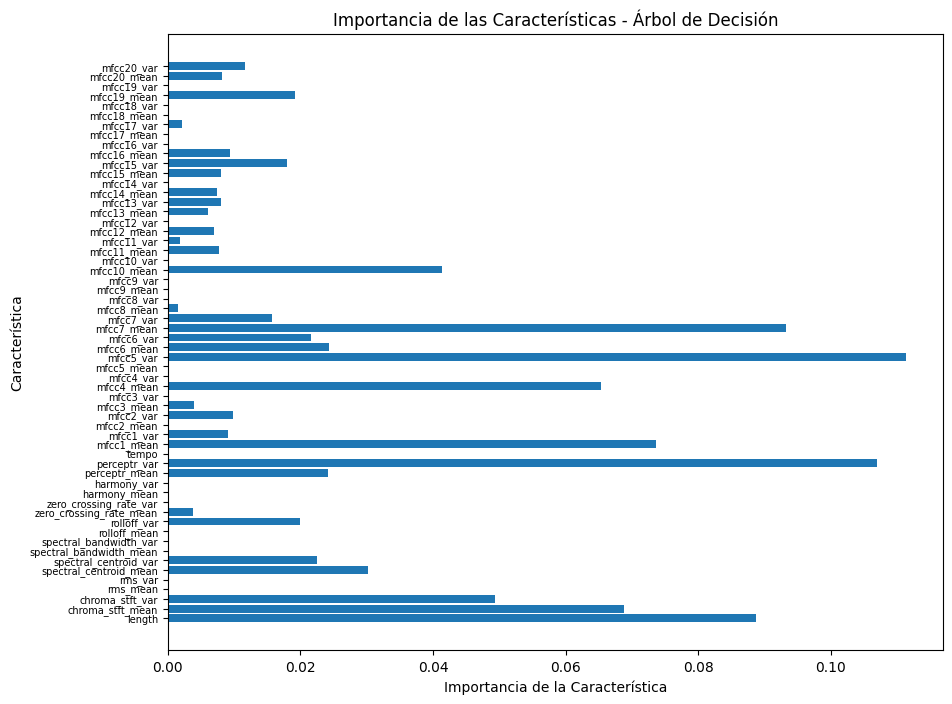

In [21]:

# Obtener la importancia de las características
importancias = best_tree.feature_importances_

# Nombres de las características para este conjunto de datos
nombres_caracteristicas = X.columns

# Crear un gráfico para visualizar la importancia de las características
plt.figure(figsize=(10, 8))
plt.barh(range(len(importancias)), importancias)
plt.yticks(np.arange(len(nombres_caracteristicas)), nombres_caracteristicas, fontsize=7)
plt.xlabel('Importancia de la Característica')
plt.ylabel('Característica')
plt.title('Importancia de las Características - Árbol de Decisión')
plt.show()

### Varianza

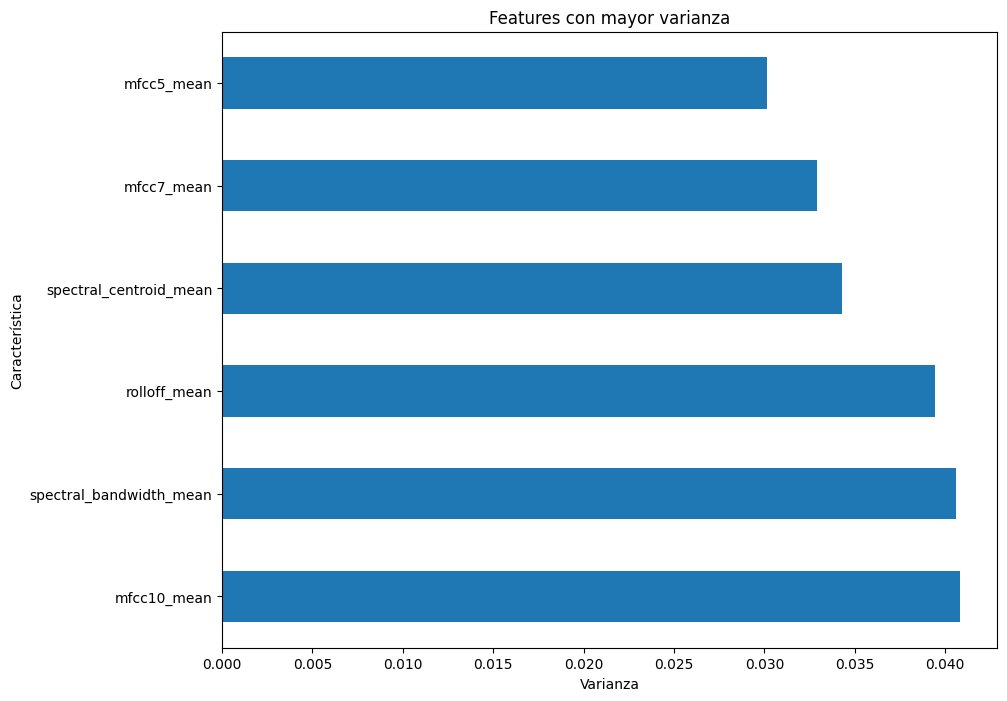

In [22]:
from sklearn.feature_selection import VarianceThreshold


# Crear un objeto VarianceThreshold con un umbral de 0.03
features = X.var(ddof = 0).sort_values(ascending = False)

# Obtener las características seleccionadas
features[features > 0.03].plot(kind = 'barh', figsize = (10, 8))
plt.xlabel('Varianza')
plt.ylabel('Característica')
plt.title('Features con mayor varianza')
plt.show()




### Recursive Feature Elimination

In [23]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression


# Crear un modelo base
modelo_base = LogisticRegression()

# Crear un selector RFE
selector = RFE(estimator=modelo_base, n_features_to_select=8, step=1)

# Aplicar el selector RFE al conjunto de datos
selector = selector.fit(X, y)

# Características seleccionadas
caracteristicas_seleccionadas = X.columns[selector.support_]

# # Características eliminadas
# caracteristicas_eliminadas = X.columns[~selector.support_]

print("Características seleccionadas:", caracteristicas_seleccionadas)

Características seleccionadas: Index(['chroma_stft_mean', 'chroma_stft_var', 'spectral_bandwidth_mean',
       'mfcc1_mean', 'mfcc4_mean', 'mfcc4_var', 'mfcc7_var', 'mfcc9_mean'],
      dtype='object')


### Sequential Feature Selection

In [24]:
from sklearn.feature_selection import SequentialFeatureSelector

# Crear un modelo base
modelo_base = LogisticRegression()

# Crear un selector SFS
selector = SequentialFeatureSelector(estimator=modelo_base, n_features_to_select=8, direction='forward')

# Aplicar el selector SFS al conjunto de datos
selector = selector.fit(X, y)

# Características seleccionadas
caracteristicas_seleccionadas = X.columns[selector.get_support(indices=True)]
print("Características seleccionadas:", caracteristicas_seleccionadas)

Características seleccionadas: Index(['chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var',
       'mfcc4_mean', 'mfcc4_var', 'mfcc5_var', 'mfcc17_mean'],
      dtype='object')


# Feature engineering

In [25]:
df_fe = df.copy()
df_fe.columns

Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

In [26]:

#elimino el nombre del archivo
df_fe = df_fe.drop(['filename'], axis=1)


In [27]:

#elimino los outliers
lof_outlier = LocalOutlierFactor(n_neighbors=8)
outlier_scores = lof_outlier.fit_predict(df_fe.select_dtypes(include=['int64', 'float64']))

#Cantidad de outliers detectados
sum(outlier_scores == -1)

36

In [28]:
mask = outlier_scores != -1
df_fe = df_fe.loc[mask,:]

In [29]:

#selecciono las features deseadas
df_fe = df_fe[['length','zero_crossing_rate_mean','chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var',
       'mfcc4_mean', 'mfcc4_var', 'mfcc5_var', 'mfcc17_mean','spectral_centroid_mean', 'spectral_bandwidth_mean',
       'mfcc1_mean','mfcc7_var', 'mfcc9_mean','mfcc10_mean', 'perceptr_var','label']]


# Ensamblado de modelos sobre nuevo df

In [30]:
y = df_fe['label'] # genre variable.
X = df_fe.loc[:, df_fe.columns != 'label'] #select all columns but not the labels

#### NORMALIZE X ####

# Normalize so everything is on the same scale.

cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

# new data frame with the new scaled data.
X = pd.DataFrame(np_scaled, columns = cols)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(df_fe['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

### xgboost

In [31]:
%%capture
!pip install xgboost


In [32]:

import xgboost
xgb_reg = xgboost.XGBClassifier(random_state=42)
xgb_reg.fit(X_train, y_train)
y_pred_xgboost = xgb_reg.predict(X_test)
print(accuracy_score(y_test, y_pred_xgboost))

0.7241379310344828


### Voting classifier

In [33]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier


r1 = LogisticRegression()
r2 = RandomForestClassifier(n_estimators=10, random_state=1)
r3 = KNeighborsClassifier()

voting_class = VotingClassifier([('lr', r1), ('rf', r2), ('r3', r3)])




voting_class.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf',
                              RandomForestClassifier(n_estimators=10,
                                                     random_state=1)),
                             ('r3', KNeighborsClassifier())])

In [34]:
for reg in (r1, r2, r3, voting_class):
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    print(reg.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.5275862068965518
RandomForestClassifier 0.6655172413793103
KNeighborsClassifier 0.6241379310344828
VotingClassifier 0.6482758620689655
